In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd 
import seaborn as sns 
import statistics
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from ydata_profiling import ProfileReport

In [4]:
%matplotlib inline

In [5]:
modeldf2019 = pd.read_csv('mydata/MMSA2019.csv',encoding='latin-1',index_col=[0])
modeldf2021 = pd.read_csv('mydata/MMSA2021.csv',encoding='latin-1',index_col=[0])

In [6]:
#pd.set_option('display.max_columns', None)

In [7]:
pd.set_option('display.max_info_columns', 1000)
pd.set_option('display.max_info_rows', 1000000)

In [8]:
import io
buffer = io.StringIO()
modeldf2019.info(buf=buffer)
info_str = buffer.getvalue()
print(info_str)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210771 entries, 1 to 210771
Data columns (total 179 columns):
 #    Column    Non-Null Count   Dtype  
---   ------    --------------   -----  
 0    DISPCODE  210771 non-null  int64  
 1    STATERE1  71738 non-null   float64
 2    CELPHONE  71738 non-null   float64
 3    LADULT1   71738 non-null   float64
 4    COLGSEX   21 non-null      float64
 5    LANDSEX   30365 non-null   float64
 6    RESPSLCT  36285 non-null   float64
 7    SAFETIME  139033 non-null  float64
 8    CADULT1   139033 non-null  float64
 9    CELLSEX   139026 non-null  float64
 10   HHADULT   139028 non-null  float64
 11   SEXVAR    210771 non-null  int64  
 12   GENHLTH   210753 non-null  float64
 13   PHYSHLTH  210750 non-null  float64
 14   MENTHLTH  210761 non-null  float64
 15   POORHLTH  116171 non-null  float64
 16   HLTHPLN1  210764 non-null  float64
 17   PERSDOC2  210765 non-null  float64
 18   MEDCOST   210765 non-null  float64
 19   CHECKUP1  210763 non-

In [9]:
buffer = io.StringIO()
modeldf2021.info(buf=buffer)
info_str = buffer.getvalue()
print(info_str)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 227792 entries, 1 to 227792
Data columns (total 152 columns):
 #    Column    Non-Null Count   Dtype  
---   ------    --------------   -----  
 0    DISPCODE  227792 non-null  int64  
 1    STATERE1  55524 non-null   float64
 2    CELPHON1  55524 non-null   float64
 3    LADULT1   55524 non-null   float64
 4    COLGSEX   18 non-null      float64
 5    LANDSEX   23345 non-null   float64
 6    RESPSLCT  30824 non-null   float64
 7    SAFETIME  172268 non-null  float64
 8    CADULT1   172268 non-null  float64
 9    CELLSEX   172267 non-null  float64
 10   HHADULT   172267 non-null  float64
 11   SEXVAR    227792 non-null  int64  
 12   GENHLTH   227790 non-null  float64
 13   PHYSHLTH  227790 non-null  float64
 14   MENTHLTH  227792 non-null  int64  
 15   POORHLTH  122851 non-null  float64
 16   PRIMINSR  227791 non-null  float64
 17   PERSDOC3  227792 non-null  int64  
 18   MEDCOST1  227791 non-null  float64
 19   CHECKUP1  227792 non-

### Converting 2019 BRFSS Dataframe Columns to appropriate datatype

In [10]:
#Any variable with value counts below 14 with be turned to a categorical nominal datatype:
# Convert 'col1' from float to categorical
for col in modeldf2019.columns:
    if len(modeldf2019[col].value_counts()) < 15:
        modeldf2019[col] = modeldf2019[col].astype('category')
        
for col in modeldf2021.columns:
    if len(modeldf2021[col].value_counts()) < 15:
        modeldf2021[col] = modeldf2021[col].astype('category')
               

In [11]:
##Extract state from MMSANAME
def get_state(col):
    return col.split(',')[1]

modeldf2019['STATE'] = modeldf2019['MMSANAME'].apply(get_state)
modeldf2021['STATE'] = modeldf2021['MMSANAME'].apply(get_state)

In [12]:
#RENAME COLUMNS in 2019 dataset to match 2021:
modeldf2019.rename(columns={'_INCOMG':'_INCOMG1','_RFHYPE5':'_RFHYPE6','HLTHPLN1': 'PRIMINSR','MEDCOST':'MEDCOST1',
                  '_RFCHOL2':'_RFCHOL3'},inplace=True)

In [13]:
#Create a _HLTHPLN from PRIMINSR IN 2019 df (- '_HLTHPLN' - Categorical variable for healthcare plan )

modeldf2019['_HLTHPLN'] = modeldf2019['PRIMINSR'].apply(lambda x: 1 if x in [1,2,3,4,5,6,7,8,9] 
                                                        else 2 if x == 88 else 'NA')

modeldf2019['_TOTINDA'] = modeldf2019['_TOTINDA'].astype(float)

#Create a DROCDY3_ from ALCDAY5 by dividing the ALCDAY5 variable by 7 days per week or 30 days per month
def compute_drocdy3_(x):
    # Handle NaN values
    if pd.isna(x):
        return np.nan
    
    x_int = int(str(x).split(".")[0])
    
    if x_int == 888:
        return 0.0
    elif x_int // 100 == 1:
        return (x_int % 100) / 7.0
    elif x_int // 100 == 2:
        return (x_int % 100) / 30.0
    elif x_int in [777, 999]:
        return np.nan
    else:
        return float(x_int)

modeldf2019['DROCDY3_'] = modeldf2019['ALCDAY5'].apply(compute_drocdy3_)
modeldf2021['DROCDY3_'] = modeldf2021['ALCDAY5'].apply(compute_drocdy3_)

In [14]:
# Get common columns
common_columns = modeldf2019.columns.intersection(modeldf2021.columns)

# 2019 indexed with common columns
brfss_df = modeldf2019[common_columns]


### Lets clean up 2019 dataset and keep as training datset

In [15]:
#Convert appropriate columns into categories
# List of columns to convert
columns_list = ['_AGE65YR', '_INCOMG1', '_TOTINDA', '_HLTHPLN', '_RFBING5', 
                'PRIMINSR', '_EDUCAG', '_SMOKER3','_RFSMOK3','_SEX', '_RFHYPE6','PHYSHLTH',
                '_RFHLTH','MENTHLTH','_AGEG5YR','_ASTHMS1','_HISPANC','ALCDAY5',
                "CHECKUP1","CVDSTRK3","CHCSCNCR","CHCOCNCR","ADDEPEV3","CHCKDNY2", "DIABETE4",'_RACE']

# Convert each column to category data type in place
for col in columns_list:
    brfss_df[col] = brfss_df[col].astype('category')

#convert height to height in meters
def calculate_htinm(height3):
    if 300 <= height3 <= 311:
        htinm = ((height3 - 300) + 36)*0.0254
    elif 400 <= height3 <= 411:
        htinm = ((height3 - 400) + 48)*0.0254
    elif 500 <= height3 <= 511:
        htinm = ((height3 - 500) + 60)*0.0254
    elif 600 <= height3 <= 611:
        htinm = ((height3 - 600) + 72)*0.0254
    elif 700 <= height3 <= 711:
        htinm = ((height3 - 700) + 84)*0.0254
    else:
        htinm = None  # Handle cases that don't match any condition
    
    return htinm

brfss_df['HEIGHT3'] = brfss_df['HEIGHT3'].apply(calculate_htinm)


In [16]:
brfss_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210771 entries, 1 to 210771
Data columns (total 136 columns):
 #    Column    Non-Null Count   Dtype   
---   ------    --------------   -----   
 0    DISPCODE  210771 non-null  category
 1    STATERE1  71738 non-null   category
 2    LADULT1   71738 non-null   category
 3    COLGSEX   21 non-null      category
 4    LANDSEX   30365 non-null   category
 5    RESPSLCT  36285 non-null   category
 6    SAFETIME  139033 non-null  category
 7    CADULT1   139033 non-null  category
 8    CELLSEX   139026 non-null  category
 9    HHADULT   139028 non-null  float64 
 10   SEXVAR    210771 non-null  category
 11   GENHLTH   210753 non-null  category
 12   PHYSHLTH  210750 non-null  category
 13   MENTHLTH  210761 non-null  category
 14   POORHLTH  116171 non-null  float64 
 15   PRIMINSR  210764 non-null  category
 16   MEDCOST1  210765 non-null  category
 17   CHECKUP1  210763 non-null  category
 18   BPMEDS    81278 non-null   category
 19   

In [17]:
#Lets make a copy of the 2019 DATAFRAME
processed_features_df = brfss_df.copy()

#Place decimal place in fruit and vegetable columns (as it was implied)
def convert_decimal(x):
    if pd.isna(x):
        return np.nan
    else:
        return x/100
    
cols = ['FRNCHDA_','POTADA1_', 'FRUTDA2_', 'FTJUDA2_', 'VEGEDA2_', 'GRENDA1_', 
                '_FRUTSU1', '_VEGESU1','WTKG3','_BMI5']

#Convert features to appropriate values by placing the decimal place 
for col in cols:
    processed_features_df[col] = processed_features_df[col].apply(convert_decimal)
    
#Convert STATE column to US state
from States import states
processed_features_df['STATE'] = processed_features_df['STATE'].apply(lambda x: states[(x[-2:])] 
                                                                      if (x[-2:]) in states else x)

In [18]:
processed_features_df.drop(columns='MMSANAME',inplace=True)

#### REPLACE NUMERIC CATEGORICAL COLUMNS WITH ACTUAL CATEGORIES FROM QUESTIONNAIRE 

In [19]:
diabetes_replace = {1:'yes', 2:'yes', 3:'no', 4:'yes', 7:np.nan, 9:np.nan}
income_replace = {1:'<15k', 2:'15k-25k', 3:'25k-35k', 4:'35k-50k', 5:'>50k',9:np.nan}
race_replace = {1:'white', 2:'black', 3:'native american', 4:'asian', 5:'native hawaiian/pacific islander', 6:'other race only', 7:'multiracial', 8:'hispanic', 9:'refused/unknown'}
age_replace = {1:'18-24', 2:'25-29', 3:'30-34', 4:'35-39', 5:'40-44', 6:'45-49', 7:'50-54', 8:'55-59', 9:'60-64', 10:'65-69', 11:'70-74', 12:'75-79', 13:'80+', 14:np.nan}
sex_replace = {1:'male', 2:'female'}
heart_disease_replace = {1:'yes', 2:'no', 7:np.nan, 9:np.nan}
heart_attack_replace = {1:'yes', 2:'no', 7:np.nan, 9:np.nan}
stroke_replace =  {1:'yes', 2:'no', 7:np.nan, 9:np.nan}
general_health_replace = {1:'excellent', 2:'very good', 3:'good', 4:'fair', 5:'poor', 7:np.nan, 9:np.nan}
physical_health_replace = {88: 0, 77: np.nan, 99: np.nan}
mental_health_replace = {88: 0, 77: np.nan, 99: np.nan}
educa_replace = {1:'none', 2:'HS_diploma', 3:'Attended_Col', 4:'College_grad',9:np.nan}
#doctor_replace = {1:'yes', 2:'yes', 3:'no', 7:np.nan, 9:np.nan}
medical_costs_replace = {1:'yes', 2:'no', 7:np.nan, 9:np.nan}
checkup_replace = {1:'1 year', 2:'2 years', 3:'5 years', 4:'>5 years', 7:'unknown', 8:'never', 9:np.nan}
exercise_replace = {1:'yes', 2:'no', 7:np.nan, 9:np.nan}
marital_replace = {1:'married', 2:'divorced', 3:'widowed', 4:'separated', 5:'single', 6:'living together', 9:np.nan}
education_replace = {1:'none', 2:'1-8', 3:'9-11', 4:'12/ged', 5:'c1-3', 6:'cg', 9:np.nan}
smoking_replace = {1:'yes', 2:'yes', 3:'no', 7:np.nan, 9:np.nan}
alcohol_replace = {777:'yes', 888:'no', 999:'no'}
toldasthma_replace = {1:'no',2:'yes',9:np.nan}
asthma_replace = {1:'current',2:'former',3:'Never',9:np.nan}
bmicat_replace = {1:'Underweight',2:'Normal Weight',3:'Overweight',4:'Obese',}
childcat_replace ={1:'No children in household',2:'One child in household',3:"Two children in household",
                   4:'Three children in household',5:'Four children in household',
                   6:'Five or more children in household',9:np.nan}
race21_replace = {1:'Non-Hispanic White',2:'Non-White or Hispanic',9:np.nan}
blind_replace = {1:'yes', 2:'no', 7:np.nan, 9:np.nan}
highblood_pressure = {1:'no',2:'yes',9:np.nan}
difficult_replace = {1:'yes', 2:'no', 7:np.nan, 9:np.nan}

hhadult_replace = {77:np.nan, 99:np.nan}
health_days_replace = {88:0,77:np.nan, 99:np.nan}
children_replace = {88:0,99:np.nan}
hw_replace = {7777:np.nan, 9999:np.nan}
fruit_replace = {777:np.nan,555:0,9:np.nan}
metric = True
max_weight = 999

#Categorical columns:
processed_features_df['_RFHYPE6'].replace(highblood_pressure,inplace=True)
processed_features_df['_RFBMI5'].replace(toldasthma_replace,inplace=True)
processed_features_df['_BMI5CAT'].replace(bmicat_replace,inplace=True)
processed_features_df['_ASTHMS1'].replace(asthma_replace,inplace=True)
processed_features_df['_CASTHM1'].replace(toldasthma_replace,inplace=True)
processed_features_df['ASTHMA3'].replace(heart_attack_replace,inplace=True)
processed_features_df['ADDEPEV3'].replace(heart_attack_replace,inplace=True)
processed_features_df['CVDCRHD4'].replace(heart_attack_replace,inplace=True)
processed_features_df['_MICHD'].replace(heart_attack_replace,inplace=True)
processed_features_df['CVDINFR4'].replace(heart_attack_replace,inplace=True)
processed_features_df['CVDSTRK3'].replace(stroke_replace,inplace=True)
processed_features_df['ALCDAY5'].replace(alcohol_replace,inplace=True)
processed_features_df['SMOKDAY2'].replace(smoking_replace,inplace=True)
processed_features_df['EDUCA'].replace(education_replace,inplace=True)
processed_features_df['GENHLTH'].replace(general_health_replace,inplace=True)
processed_features_df['PHYSHLTH'].replace(physical_health_replace,inplace=True)
processed_features_df['MENTHLTH'].replace(mental_health_replace,inplace=True)
processed_features_df['CHECKUP1'].replace(checkup_replace,inplace=True)
processed_features_df['MEDCOST1'].replace(medical_costs_replace,inplace=True)
processed_features_df['MARITAL'].replace(marital_replace,inplace=True)
processed_features_df['EXERANY2'].replace(exercise_replace,inplace=True)
processed_features_df['_INCOMG1'].replace(income_replace,inplace=True)
processed_features_df['_RACE'].replace(race_replace,inplace=True)
processed_features_df['_AGEG5YR'].replace(age_replace,inplace=True)
processed_features_df['_SEX'].replace(sex_replace,inplace=True)
processed_features_df['HEIGHT3'].replace(hw_replace,inplace=True)
processed_features_df['WEIGHT2'].replace(hw_replace,inplace=True)
processed_features_df['DIABETE4'].replace(diabetes_replace,inplace=True)
processed_features_df['_RACEG21'].replace(race21_replace,inplace=True)
processed_features_df['BLIND'].replace(blind_replace,inplace=True)
processed_features_df['DIFFALON'].replace(difficult_replace,inplace=True)
processed_features_df['DIFFDRES'].replace(difficult_replace,inplace=True)
processed_features_df['DECIDE'].replace(difficult_replace,inplace=True)
processed_features_df['DIFFWALK'].replace(difficult_replace,inplace=True)
processed_features_df['_EDUCAG'].replace(educa_replace,inplace=True)

#numerical columns:
processed_features_df['PHYSHLTH'].replace(health_days_replace,inplace=True)
processed_features_df['MENTHLTH'].replace(health_days_replace,inplace=True)
processed_features_df['POORHLTH'].replace(health_days_replace,inplace=True)
processed_features_df['HHADULT'].replace(hhadult_replace,inplace=True)
processed_features_df['CHILDREN'].replace(children_replace,inplace=True)


column_names = ["FRUIT2", "FRUITJU2", "FVGREEN1", "FRENCHF1", "POTATOE1", "VEGETAB2"]

for column in column_names:
    processed_features_df[column].replace(fruit_replace, inplace=True)

In [20]:
pd.set_option('display.max_info_columns', 1000)

In [21]:
columns_list = [
    "_RFHYPE6", 
    "_RFBMI5", 
    "_BMI5CAT", 
    "_ASTHMS1", 
    "_CASTHM1", 
    "ASTHMA3", 
    "ADDEPEV3", 
    "CVDCRHD4", 
    "_MICHD", 
    "CVDINFR4", 
    "CVDSTRK3", 
    "ALCDAY5", 
    "SMOKDAY2", 
    "EDUCA", 
    "GENHLTH", 
    "PHYSHLTH", 
    "MENTHLTH", 
    "CHECKUP1", 
    "MEDCOST1", 
    "MARITAL", 
    "EXERANY2", 
    "_INCOMG1", 
    "_RACE", 
    "_AGEG5YR", 
    "_SEX", 
    "HEIGHT3", 
    "WEIGHT2", 
    "DIABETE4", 
    "_RACEG21", 
    "BLIND", 
    "DIFFALON", 
    "DIFFDRES", 
    "DECIDE", 
    "DIFFWALK"
]

processed_features_df[columns_list].head()

_RFHYPE6 _RFBMI5       _BMI5CAT _ASTHMS1 _CASTHM1 ASTHMA3 ADDEPEV3 CVDCRHD4  \
1       no      no  Normal Weight    Never       no      no      yes       no   
2       no     yes     Overweight    Never       no      no       no       no   
3       no     yes     Overweight    Never       no      no       no       no   
4       no     NaN            NaN    Never       no      no       no       no   
5       no     yes          Obese    Never       no      no       no       no   

  _MICHD CVDINFR4  ...    _SEX HEIGHT3 WEIGHT2 DIABETE4            _RACEG21  \
1     no       no  ...    male  1.8288   145.0       no  Non-Hispanic White   
2     no       no  ...    male  1.7780   180.0       no  Non-Hispanic White   
3    yes      yes  ...    male  1.7780   200.0      yes  Non-Hispanic White   
4     no       no  ...  female  1.8034     NaN       no  Non-Hispanic White   
5     no       no  ...    male  1.8034   265.0      yes  Non-Hispanic White   

   BLIND  DIFFALON DIFFDRES DECIDE DIFFWALK  
1     no        no       no     no       no  
2     no        no       no     no       no  
3     no        no       no    yes      yes  
4     no        no       no     no       no  
5     no        no       no     no       no  

[5 rows x 34 columns]

### Generate EDA Report with Original Dataset

In [22]:
#profile = ProfileReport(modeldf2019)
#profile.to_file(output_file="mydata/EDA_Report_2019.html")

### Handle Missing data

In [23]:
pd.reset_option('display.max_rows',None)

In [24]:
#check missing values in train dataset
total = processed_features_df.isnull().sum().sort_values(ascending=False)
percent = (processed_features_df.isnull().sum()/processed_features_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print(missing_data.to_string())

           Total   Percent
COLGSEX   210750  0.999900
NUMPHON3  192684  0.914186
CAGEG     185674  0.880928
DIABAGE3  183766  0.871875
ASTHNOW   180692  0.857291
LANDSEX   180406  0.855934
RESPSLCT  174486  0.827846
PREGNANT  171430  0.813347
ARTHDIS2  144913  0.687538
LMTJOIN3  144911  0.687528
ARTHEDU   144910  0.687523
JOINPAI2  144910  0.687523
ARTHEXER  144909  0.687519
HIVTSTD3  142395  0.675591
NUMHHOL3  139607  0.662363
STATERE1  139033  0.659640
LADULT1   139033  0.659640
_PNEUMO3  134644  0.638817
_FLSHOT7  134644  0.638817
SMOKDAY2  130511  0.619208
BPMEDS    129493  0.614378
FLSHTMY3  113726  0.539571
MAXDRNKS  105730  0.501634
DRNK3GE5  105615  0.501089
AVEDRNK3  105247  0.499343
POORHLTH   97676  0.463422
HHADULT    72677  0.344815
CELLSEX    71745  0.340393
CADULT1    71738  0.340360
SAFETIME   71738  0.340360
_INCOMG1   40261  0.191018
_VEGESU1   27521  0.130573
_RFCHOL3   23836  0.113090
_FRUTSU1   23119  0.109688
VEGEDA2_   22774  0.108051
VEGETAB2   22319  0.105892
P

In [25]:
#Drop columns with more that 45% missing values 
col_more45 = list(missing_data.index[missing_data['Percent'] > 0.45])
col_more45
processed_features_df.drop(columns=col_more45,inplace=True)

#Drop columns that are of very low variance and have high unique values and may be of no importance to ones health
processed_features_df.drop(columns=['SAFETIME','CELLSEX',
                                    'SEQNO','CADULT1'],inplace=True)

#Drop these fruit/Veg columns as they ahve already been interpreted in other columns:
processed_features_df.drop(columns=['VEGETAB2','POTATOE1','FRENCHF1',
                                    'FVGREEN1','FRUITJU2','FRUIT2'],inplace=True)

#CADULT1- Are you 18 years of age or older? if not survey was terminated hence everyone interviewed was 18yrs
#SAFETIME- Is this a safe time to talk with you?
#CELLSEX- Are you male or female? reflected by _SEX
#SEQNO- its like an ID

processed_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210771 entries, 1 to 210771
Data columns (total 99 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   DISPCODE  210771 non-null  category
 1   HHADULT   138094 non-null  float64 
 2   SEXVAR    210771 non-null  category
 3   GENHLTH   210282 non-null  object  
 4   PHYSHLTH  205752 non-null  float64 
 5   MENTHLTH  206532 non-null  float64 
 6   PRIMINSR  210764 non-null  category
 7   MEDCOST1  210154 non-null  object  
 8   CHECKUP1  210559 non-null  object  
 9   CVDINFR4  209607 non-null  object  
 10  CVDCRHD4  208952 non-null  object  
 11  CVDSTRK3  210097 non-null  object  
 12  ASTHMA3   210011 non-null  object  
 13  CHCSCNCR  210764 non-null  category
 14  CHCOCNCR  210763 non-null  category
 15  ADDEPEV3  209581 non-null  object  
 16  CHCKDNY2  210763 non-null  category
 17  DIABETE4  210340 non-null  object  
 18  MARITAL   208744 non-null  object  
 19  EDUCA     209716 non-nu

In [26]:
processed_features_df['_SEX'].value_counts()

female    114650
male       96121
Name: _SEX, dtype: int64

In [27]:
#replace the missing values in height with the mean for males and mean for females as it is normally distributed 

# Fill missing heights with the mean height for each gender
processed_features_df['HEIGHT3'].fillna(processed_features_df.groupby('_SEX')['HEIGHT3'].transform('mean'), inplace=True)

In [28]:
#replace the missing values in weight with the mean for males and mean for females as it is normally distributed 
#'WTKG3' - Weight in KG
#'WEIGHT2' - Weight in pounds

# Replace missing values with the corresponding mean weight value
processed_features_df['WTKG3'].fillna(processed_features_df.groupby('_SEX')['WTKG3'].transform('mean'), inplace=True)

# Replace missing values with the corresponding mean weight value
processed_features_df['WEIGHT2'].fillna(processed_features_df.groupby('_SEX')['WEIGHT2'].transform('mean'), inplace=True)

In [29]:
#Fill in the missing _BMI5 values with the calculated value from weight and height 

# Replace missing values with the Calculated BMI value
processed_features_df['_BMI5'].fillna(processed_features_df['WTKG3'] / processed_features_df['HEIGHT3']**2, inplace=True)

#fill in the missing _BMICAT5 categories with the alotted categories based on _BMI5
def categorize_bmi(_BMI5):
    if 0.00 <= _BMI5 < 18.50:
        return 1
    elif 18.50 <= _BMI5 < 25.00:
        return 2
    elif 25.00 <= _BMI5 < 30.00:
        return 3
    elif _BMI5 >= 30.00:
        return 4
    else:
        return None  # Handle other possible cases (e.g. negative BMI or None)
    
def four_cat_bmi(_BMI5):
    if 12.00 <= _BMI5 < 25.00:
        
        return 'no'
    elif 25.00 <= _BMI5 < 99.99:
        
        return 'yes'
    else:
         np.nan

processed_features_df['_BMI5CAT']= processed_features_df['_BMI5'].apply(categorize_bmi)
processed_features_df['_RFBMI5'] = processed_features_df['_BMI5'].apply(four_cat_bmi)
processed_features_df['_BMI5CAT'] = processed_features_df['_BMI5CAT'].astype('category')


In [30]:
#The missing values in _RFCHOL3 are filled in a way that preserves the ratio of its subcategories. 
#This can be useful if you believe that the observed distribution is representative and want 
#the filled values to reflect that same distribution.

# Find distribution of non-missing values
value_counts = processed_features_df['_RFCHOL3'].value_counts(normalize=True)

# Fill missing values by sampling based on this distribution
missing_count = processed_features_df['_RFCHOL3'].isna().sum()
if missing_count > 0:
    imputed_values = np.random.choice(value_counts.index, 
                                      p=value_counts.values, 
                                      size=missing_count)
    processed_features_df.loc[processed_features_df['_RFCHOL3'].isna(), '_RFCHOL3'] = imputed_values

In [31]:
#Replace missing fruit and vegetable column values with the median value for each race & Age category assuming that
#different races and ages tend to have different diets
fruit_veg_columns = [
    '_VEGESU1',
    '_FRUTSU1',
    'VEGEDA2_',
    'POTADA1_',
    'FRNCHDA_',
    'FTJUDA2_',
    'GRENDA1_',
    'FRUTDA2_',
]

for col in fruit_veg_columns:
    medians = processed_features_df.groupby(['_RACE', '_AGEG5YR'])[col].transform('median')
    processed_features_df[col].fillna(medians, inplace=True)


In [32]:
#Replace Missing Income data with the median income per Race, sex,age and education 
medians = processed_features_df.groupby(['_RACE','_AGEG5YR','_SEX','_EDUCAG'])[col].transform('median')
processed_features_df['_INCOMG1'].fillna(medians, inplace=True)

<Axes: >

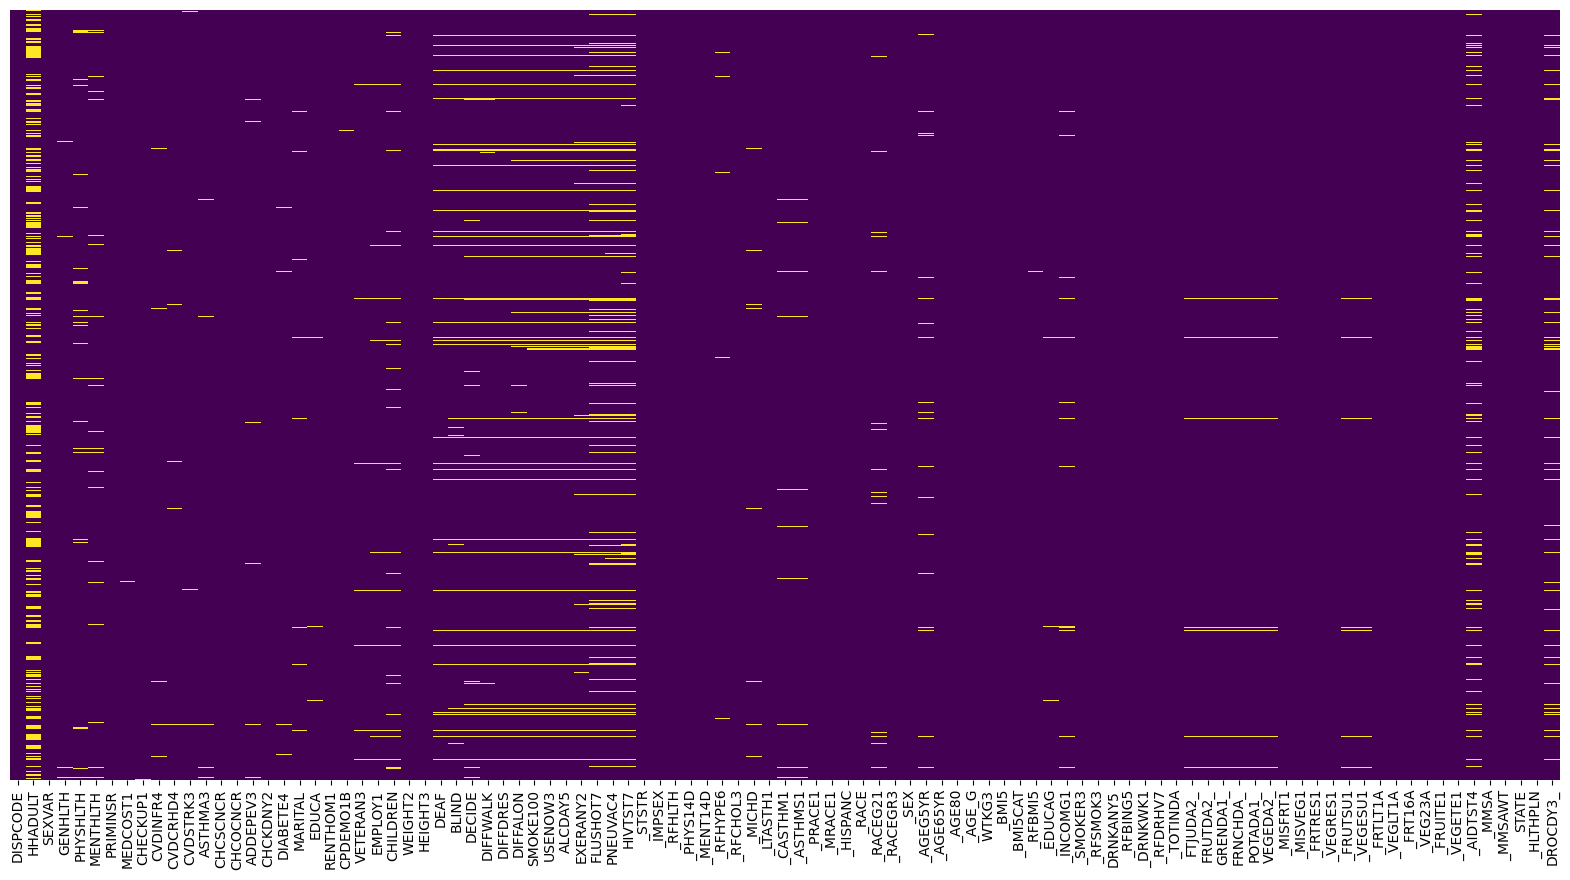

In [33]:
#vizualize misisng values using a heatmap
plt.figure(figsize=(20,10))
sns.heatmap(processed_features_df.isnull(),yticklabels=False,cmap='viridis',cbar=False)

In [34]:
#Drop the rows where columns have less than 5% missing values 
#list of columns with less than 5% missing data 
total = processed_features_df.isnull().sum().sort_values(ascending=False)
percent = (processed_features_df.isnull().sum()/processed_features_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

col_less5miss = list(missing_data.index[missing_data['Percent'] < 0.05])
col_less5miss
processed_features_df.dropna(subset=col_less5miss,inplace=True)

total = processed_features_df.isnull().sum().sort_values(ascending=False)
percent = (processed_features_df.isnull().sum()/processed_features_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

print(missing_data.to_string())

          Total   Percent
HHADULT   59881  0.337270
HIVTST7    9715  0.054718
_AIDTST4   9715  0.054718
PNEUVAC4   8521  0.047993
FLUSHOT7   7989  0.044997
DROCDY3_   1554  0.008753
EXERANY2   1453  0.008184
DRNKANY5      0  0.000000
_RFSMOK3      0  0.000000
_SMOKER3      0  0.000000
_INCOMG1      0  0.000000
_EDUCAG       0  0.000000
_RFBMI5       0  0.000000
_BMI5CAT      0  0.000000
_BMI5         0  0.000000
_DRNKWK1      0  0.000000
WTKG3         0  0.000000
_AGE_G        0  0.000000
_AGE80        0  0.000000
_AGE65YR      0  0.000000
_AGEG5YR      0  0.000000
_SEX          0  0.000000
_RACEGR3      0  0.000000
_RACEG21      0  0.000000
_RACE         0  0.000000
_RFBING5      0  0.000000
_RFDRHV7      0  0.000000
_MRACE1       0  0.000000
_VEGESU1      0  0.000000
_HLTHPLN      0  0.000000
STATE         0  0.000000
_MMSAWT       0  0.000000
_MMSA         0  0.000000
_VEGETE1      0  0.000000
_FRUITE1      0  0.000000
_VEG23A       0  0.000000
_FRT16A       0  0.000000
_VEGLT1A    

In [35]:
#Drop rows where these columns are null
cols = list(missing_data.index[missing_data['Percent'] > 0])
processed_features_df.dropna(subset=cols,inplace=True)

In [36]:
#check missing values in train dataset
total = processed_features_df.isnull().sum().sort_values(ascending=False)
percent = (processed_features_df.isnull().sum()/processed_features_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
#print(missing_data.to_string())

In [37]:
#Drop all rows with any NA values 
processed_features_df.dropna(inplace=True)
processed_features_df.reset_index(drop=True, inplace=True)
processed_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109682 entries, 0 to 109681
Data columns (total 99 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   DISPCODE  109682 non-null  category
 1   HHADULT   109682 non-null  float64 
 2   SEXVAR    109682 non-null  category
 3   GENHLTH   109682 non-null  object  
 4   PHYSHLTH  109682 non-null  float64 
 5   MENTHLTH  109682 non-null  float64 
 6   PRIMINSR  109682 non-null  category
 7   MEDCOST1  109682 non-null  object  
 8   CHECKUP1  109682 non-null  object  
 9   CVDINFR4  109682 non-null  object  
 10  CVDCRHD4  109682 non-null  object  
 11  CVDSTRK3  109682 non-null  object  
 12  ASTHMA3   109682 non-null  object  
 13  CHCSCNCR  109682 non-null  category
 14  CHCOCNCR  109682 non-null  category
 15  ADDEPEV3  109682 non-null  object  
 16  CHCKDNY2  109682 non-null  category
 17  DIABETE4  109682 non-null  object  
 18  MARITAL   109682 non-null  object  
 19  EDUCA     109682 non-nu

<Axes: >

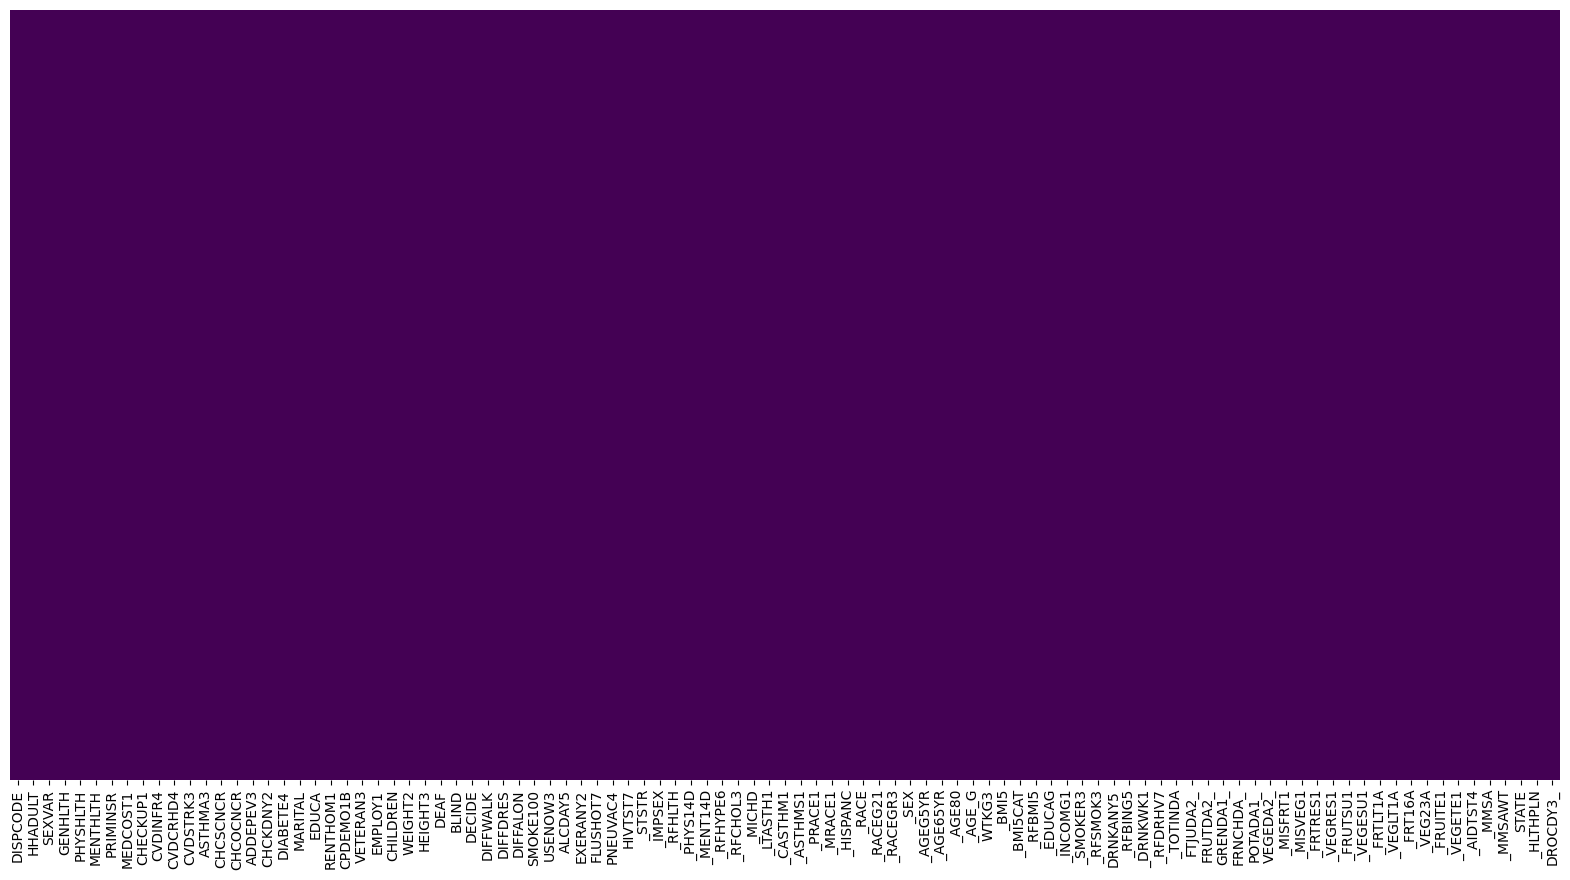

In [38]:
#vizualize misisng values using a heatmap
plt.figure(figsize=(20,10))
sns.heatmap(processed_features_df.isnull(),yticklabels=False,cmap='viridis',cbar=False)

In [39]:
#Lets Generate A profile report of the cleaned data
profile = ProfileReport(processed_features_df,minimal=True,dark_mode=True)
profile.to_file(output_file="mydata/2019_Cleaned.html")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [40]:
processed_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109682 entries, 0 to 109681
Data columns (total 99 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   DISPCODE  109682 non-null  category
 1   HHADULT   109682 non-null  float64 
 2   SEXVAR    109682 non-null  category
 3   GENHLTH   109682 non-null  object  
 4   PHYSHLTH  109682 non-null  float64 
 5   MENTHLTH  109682 non-null  float64 
 6   PRIMINSR  109682 non-null  category
 7   MEDCOST1  109682 non-null  object  
 8   CHECKUP1  109682 non-null  object  
 9   CVDINFR4  109682 non-null  object  
 10  CVDCRHD4  109682 non-null  object  
 11  CVDSTRK3  109682 non-null  object  
 12  ASTHMA3   109682 non-null  object  
 13  CHCSCNCR  109682 non-null  category
 14  CHCOCNCR  109682 non-null  category
 15  ADDEPEV3  109682 non-null  object  
 16  CHCKDNY2  109682 non-null  category
 17  DIABETE4  109682 non-null  object  
 18  MARITAL   109682 non-null  object  
 19  EDUCA     109682 non-nu

In [41]:
processed_features_df.describe([0.25,0.50,0.75,0.99]).T

count          mean           std           min           25%  \
HHADULT   109682.0      2.154200      1.095619      1.000000      1.000000   
PHYSHLTH  109682.0      3.807571      8.127675      0.000000      0.000000   
MENTHLTH  109682.0      4.143460      8.089155      0.000000      0.000000   
CHILDREN  109682.0      0.666946      1.124727      0.000000      0.000000   
WEIGHT2   109682.0    224.030380    604.151238     69.000000    150.000000   
HEIGHT3   109682.0      1.709630      0.105508      0.914400      1.625600   
_STSTR    109682.0  24546.824347  15029.170296   1019.000000  13049.000000   
_AGE80    109682.0     48.271804     17.129014     18.000000     34.000000   
WTKG3     109682.0     82.609347     20.705380     31.300000     68.040000   
_BMI5     109682.0     28.208386      6.344577     12.050000     23.910000   
_DRNKWK1  109682.0   1232.546826   9464.392163      0.000000      0.000000   
FTJUDA2_  109682.0      0.295537      1.107101      0.000000      0.000000   
FRUTDA2_  109682.0      1.122632      1.532591      0.000000      0.430000   
GRENDA1_  109682.0      0.603562      1.190064      0.000000      0.140000   
FRNCHDA_  109682.0      0.225575      0.582937      0.000000      0.030000   
POTADA1_  109682.0      0.218762      0.518701      0.000000      0.030000   
VEGEDA2_  109682.0      0.960205      1.514528      0.000000      0.430000   
_FRUTSU1  109682.0      1.414079      1.982734      0.000000      0.570000   
_VEGESU1  109682.0      1.997333      2.464451      0.000000      1.140000   
_MMSA     109682.0  31575.291278  11224.841966  10100.000000  20260.000000   
_MMSAWT   109682.0    891.571157   1431.790409      2.425378    208.998352   
DROCDY3_  109682.0      0.172723      0.267726      0.000000      0.000000   

                   50%           75%          99%           max  
HHADULT       2.000000      3.000000      6.00000     43.000000  
PHYSHLTH      0.000000      3.000000     30.00000     30.000000  
MENTHLTH      0.000000      4.000000     30.00000     30.000000  
CHILDREN      0.000000      1.000000      4.00000     15.000000  
WEIGHT2     180.000000    208.000000    348.19000   9350.000000  
HEIGHT3       1.701800      1.781198      1.93040      2.387600  
_STSTR    24039.000000  38019.000000  51029.00000  52109.000000  
_AGE80       49.000000     62.000000     80.00000     80.000000  
WTKG3        79.380000     92.990000    145.15000    276.690000  
_BMI5        27.260000     31.190000     48.81000     94.630000  
_DRNKWK1     47.000000    350.000000  15307.00000  99900.000000  
FTJUDA2_      0.030000      0.290000      3.00000     90.000000  
FRUTDA2_      1.000000      1.330000      5.00000     92.000000  
GRENDA1_      0.430000      0.710000      4.00000     90.000000  
FRNCHDA_      0.140000      0.290000      1.00000     50.000000  
POTADA1_      0.140000      0.290000      1.00000     30.000000  
VEGEDA2_      0.830000      1.000000      5.00000     90.000000  
_FRUTSU1      1.000000      2.000000      6.00000     96.000000  
_VEGESU1      1.630000      2.280000      8.27000    120.300000  
_MMSA     33460.000000  40340.000000  48864.00000  49660.000000  
_MMSAWT     449.561873   1006.506873   6578.41186  42821.380975  
DROCDY3_      0.033333      0.233333      1.00000      1.000000

In [42]:
# Replace outliers with the 99 percentile value except weight column

num_cols = processed_features_df.select_dtypes(include=('float','int')).columns
num_cols = num_cols.drop(['_MMSA','_MMSAWT','_STSTR'])
for i in num_cols:
    percentile_99 = np.percentile(processed_features_df[i], 99)
    processed_features_df.loc[processed_features_df[i] > percentile_99, i] = percentile_99


In [43]:
#processed_features_df['POORHLTH'] = processed_features_df['POORHLTH'].astype('category')

In [44]:
processed_features_df.describe([0.25,0.50,0.75,0.99]).T

count          mean           std           min           25%  \
HHADULT   109682.0      2.144481      1.031843      1.000000      1.000000   
PHYSHLTH  109682.0      3.807571      8.127675      0.000000      0.000000   
MENTHLTH  109682.0      4.143460      8.089155      0.000000      0.000000   
CHILDREN  109682.0      0.651556      1.059835      0.000000      0.000000   
WEIGHT2   109682.0    183.609759     46.004361     69.000000    150.000000   
HEIGHT3   109682.0      1.709138      0.104271      0.914400      1.625600   
_STSTR    109682.0  24546.824347  15029.170296   1019.000000  13049.000000   
_AGE80    109682.0     48.271804     17.129014     18.000000     34.000000   
WTKG3     109682.0     82.415807     19.923426     31.300000     68.040000   
_BMI5     109682.0     28.145438      6.063507     12.050000     23.910000   
_DRNKWK1  109682.0    463.455079   1676.173700      0.000000      0.000000   
FTJUDA2_  109682.0      0.261356      0.487878      0.000000      0.000000   
FRUTDA2_  109682.0      1.078249      0.961382      0.000000      0.430000   
GRENDA1_  109682.0      0.563011      0.610680      0.000000      0.140000   
FRNCHDA_  109682.0      0.201442      0.228244      0.000000      0.030000   
POTADA1_  109682.0      0.196706      0.221383      0.000000      0.030000   
VEGEDA2_  109682.0      0.906160      0.812239      0.000000      0.430000   
_FRUTSU1  109682.0      1.344594      1.141863      0.000000      0.570000   
_VEGESU1  109682.0      1.899588      1.314184      0.000000      1.140000   
_MMSA     109682.0  31575.291278  11224.841966  10100.000000  20260.000000   
_MMSAWT   109682.0    891.571157   1431.790409      2.425378    208.998352   
DROCDY3_  109682.0      0.172723      0.267726      0.000000      0.000000   

                   50%           75%          99%           max  
HHADULT       2.000000      3.000000      6.00000      6.000000  
PHYSHLTH      0.000000      3.000000     30.00000     30.000000  
MENTHLTH      0.000000      4.000000     30.00000     30.000000  
CHILDREN      0.000000      1.000000      4.00000      4.000000  
WEIGHT2     180.000000    208.000000    348.03610    348.190000  
HEIGHT3       1.701800      1.781198      1.93040      1.930400  
_STSTR    24039.000000  38019.000000  51029.00000  52109.000000  
_AGE80       49.000000     62.000000     80.00000     80.000000  
WTKG3        79.380000     92.990000    145.15000    145.150000  
_BMI5        27.260000     31.190000     48.81000     48.810000  
_DRNKWK1     47.000000    350.000000  15307.00000  15307.000000  
FTJUDA2_      0.030000      0.290000      3.00000      3.000000  
FRUTDA2_      1.000000      1.330000      5.00000      5.000000  
GRENDA1_      0.430000      0.710000      4.00000      4.000000  
FRNCHDA_      0.140000      0.290000      1.00000      1.000000  
POTADA1_      0.140000      0.290000      1.00000      1.000000  
VEGEDA2_      0.830000      1.000000      5.00000      5.000000  
_FRUTSU1      1.000000      2.000000      6.00000      6.000000  
_VEGESU1      1.630000      2.280000      8.27000      8.270000  
_MMSA     33460.000000  40340.000000  48864.00000  49660.000000  
_MMSAWT     449.561873   1006.506873   6578.41186  42821.380975  
DROCDY3_      0.033333      0.233333      1.00000      1.000000

- We can see the presence of significant multicolinearity between the fruits and vegetable columns, which we will
look to remove further down the line 

#### Export the processed df out to be split into training and validation data

In [45]:
processed_features_df.to_csv('mydata/MMSA2019_Cleaned.csv', index=False)

### EXPLORATORY DATA ANALYSIS

<Axes: >

<Figure size 1200x800 with 0 Axes>

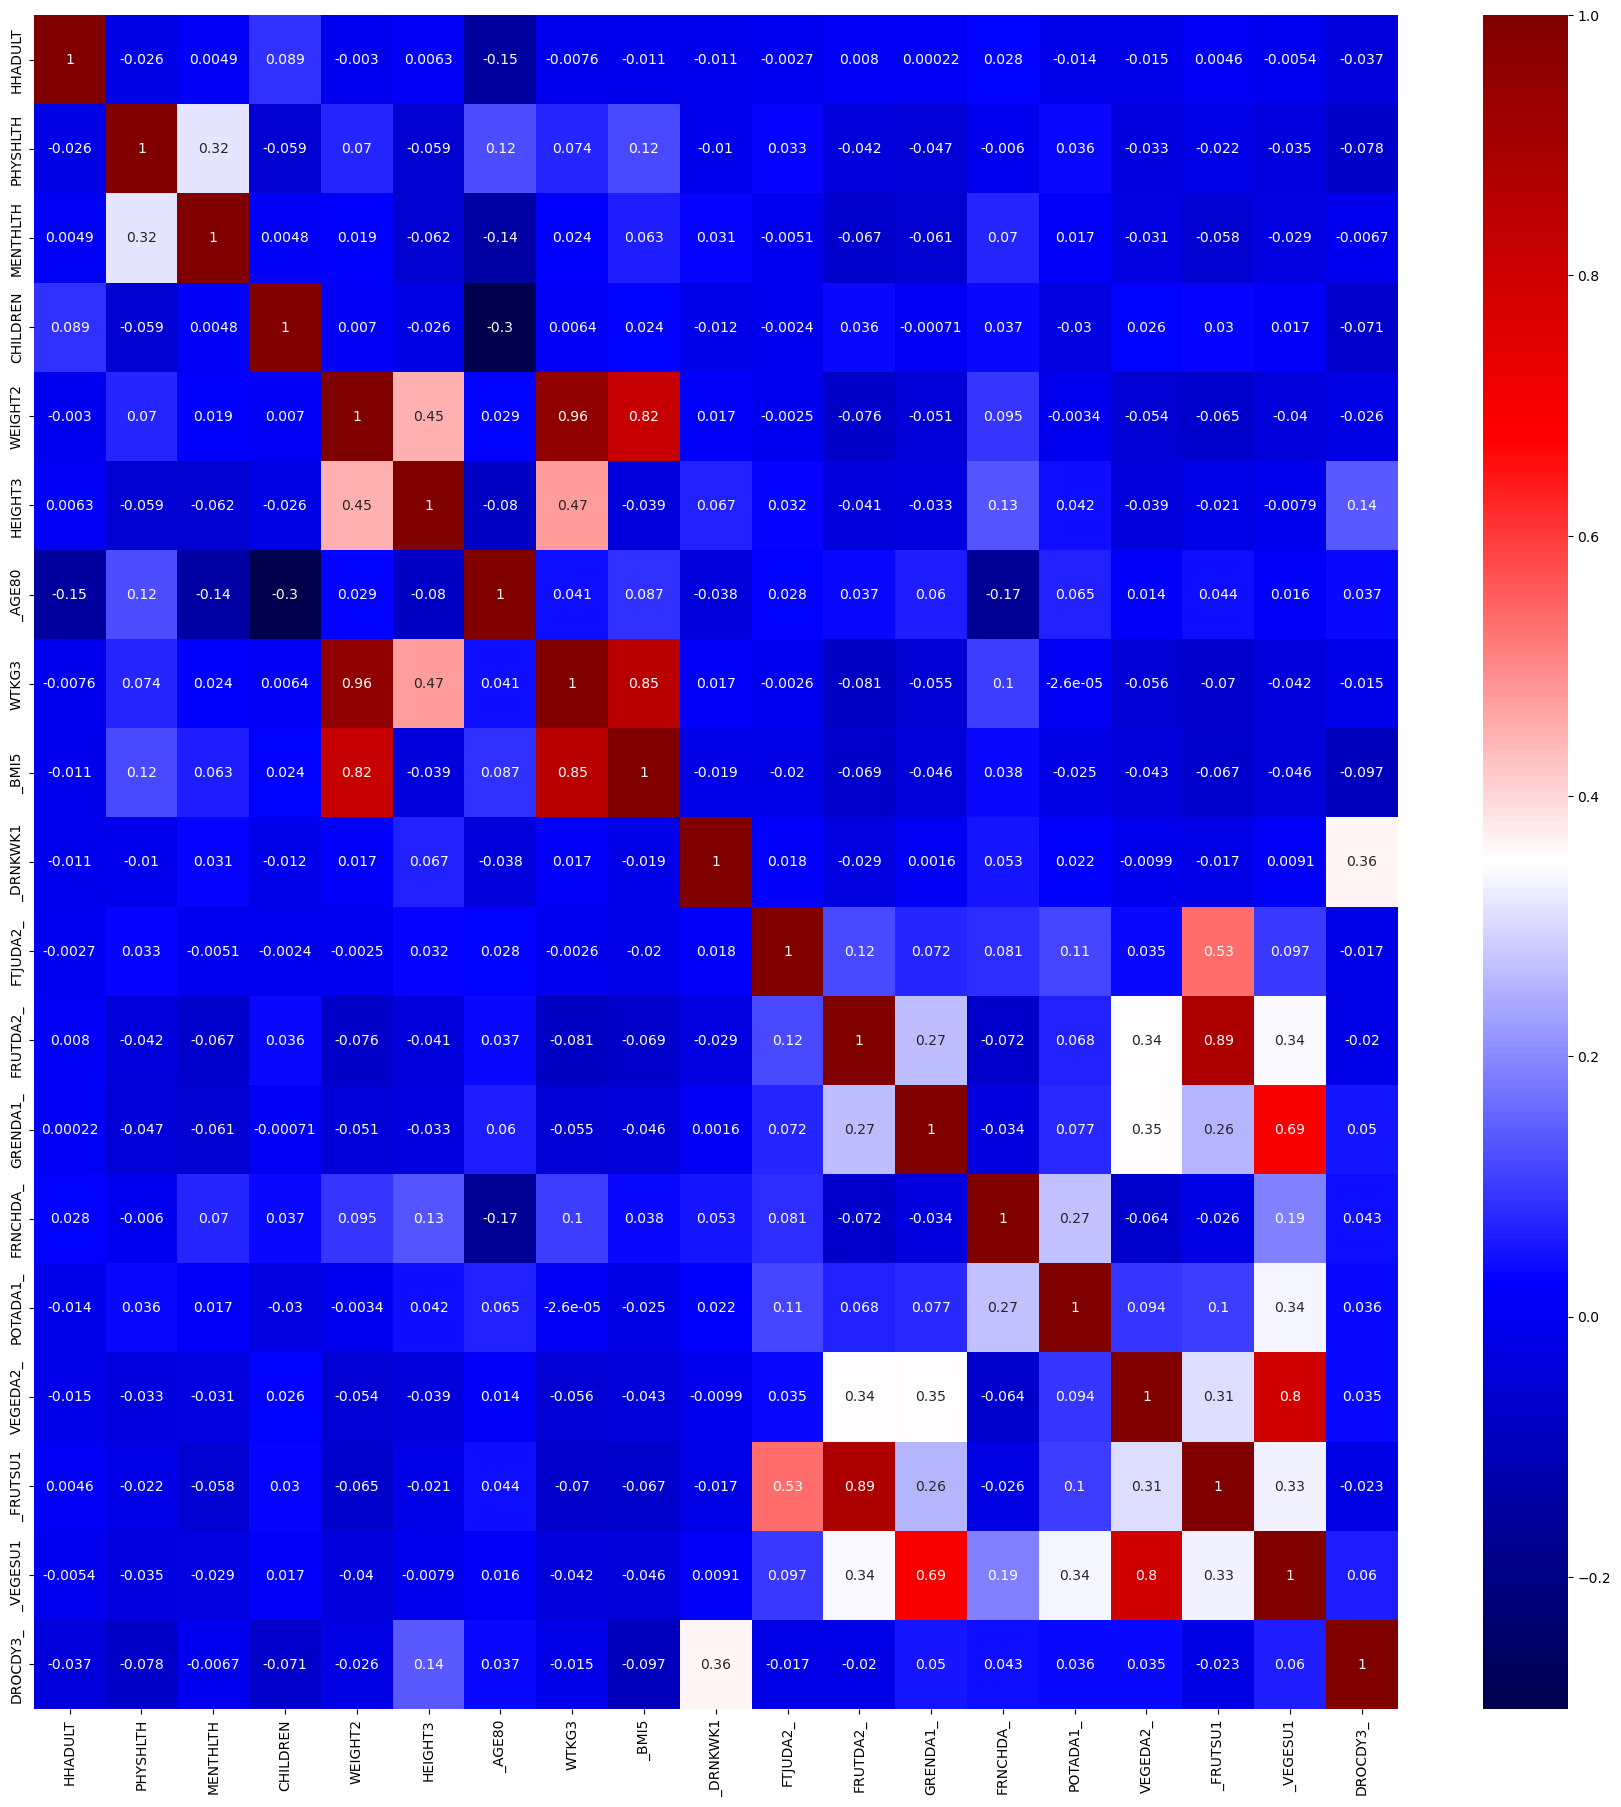

In [46]:
#Chesk for correlation between the numeric vairbales 
plt.figure(figsize=(12,8))
plt.figure(figsize=(22,22))
sns.heatmap(processed_features_df[num_cols].corr(),cmap='seismic',annot=True)

In [47]:
num_cols = processed_features_df.select_dtypes(include=('float','int')).columns
cat_cols = processed_features_df.select_dtypes(exclude=('float','int')).columns

In [48]:
cat_cols 

Index(['DISPCODE', 'SEXVAR', 'GENHLTH', 'PRIMINSR', 'MEDCOST1', 'CHECKUP1',
       'CVDINFR4', 'CVDCRHD4', 'CVDSTRK3', 'ASTHMA3', 'CHCSCNCR', 'CHCOCNCR',
       'ADDEPEV3', 'CHCKDNY2', 'DIABETE4', 'MARITAL', 'EDUCA', 'RENTHOM1',
       'CPDEMO1B', 'VETERAN3', 'EMPLOY1', 'DEAF', 'BLIND', 'DECIDE',
       'DIFFWALK', 'DIFFDRES', 'DIFFALON', 'SMOKE100', 'USENOW3', 'ALCDAY5',
       'EXERANY2', 'FLUSHOT7', 'PNEUVAC4', 'HIVTST7', '_IMPSEX', '_RFHLTH',
       '_PHYS14D', '_MENT14D', '_RFHYPE6', '_RFCHOL3', '_MICHD', '_LTASTH1',
       '_CASTHM1', '_ASTHMS1', '_PRACE1', '_MRACE1', '_HISPANC', '_RACE',
       '_RACEG21', '_RACEGR3', '_SEX', '_AGEG5YR', '_AGE65YR', '_AGE_G',
       '_BMI5CAT', '_RFBMI5', '_EDUCAG', '_INCOMG1', '_SMOKER3', '_RFSMOK3',
       'DRNKANY5', '_RFBING5', '_RFDRHV7', '_TOTINDA', '_MISFRT1', '_MISVEG1',
       '_FRTRES1', '_VEGRES1', '_FRTLT1A', '_VEGLT1A', '_FRT16A', '_VEG23A',
       '_FRUITE1', '_VEGETE1', '_AIDTST4', 'STATE', '_HLTHPLN'],
      dtype='object')

In [49]:
#here we want to print out the value count in eah categorical column

# normalize used to get the percentage 
for i in list(cat_cols):
    print(processed_features_df[i].value_counts(normalize=True))
    print('**********************************')

1100    0.87689
1200    0.12311
Name: DISPCODE, dtype: float64
**********************************
2    0.506391
1    0.493609
Name: SEXVAR, dtype: float64
**********************************
very good    0.348207
good         0.307060
excellent    0.187214
fair         0.121478
poor         0.036041
Name: GENHLTH, dtype: float64
**********************************
1.0    0.896355
2.0    0.100108
7.0    0.002826
9.0    0.000711
Name: PRIMINSR, dtype: float64
**********************************
no     0.876607
yes    0.123393
Name: MEDCOST1, dtype: float64
**********************************
1 year      0.759869
2 years     0.113072
5 years     0.062435
>5 years    0.049361
unknown     0.008908
never       0.006355
Name: CHECKUP1, dtype: float64
**********************************
no     0.962729
yes    0.037271
Name: CVDINFR4, dtype: float64
**********************************
no     0.962601
yes    0.037399
Name: CVDCRHD4, dtype: float64
**********************************
no     0.970068
yes

In [50]:
num_cols

Index(['HHADULT', 'PHYSHLTH', 'MENTHLTH', 'CHILDREN', 'WEIGHT2', 'HEIGHT3',
       '_STSTR', '_AGE80', 'WTKG3', '_BMI5', '_DRNKWK1', 'FTJUDA2_',
       'FRUTDA2_', 'GRENDA1_', 'FRNCHDA_', 'POTADA1_', 'VEGEDA2_', '_FRUTSU1',
       '_VEGESU1', '_MMSA', '_MMSAWT', 'DROCDY3_'],
      dtype='object')

In [51]:
from sklearn.ensemble._forest import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split

In [52]:
#lets create a new data frame with only dummmy categorical data and num columns 

dummies_df = processed_features_df[num_cols]
cat_cols = cat_cols.drop('GENHLTH')

for i in cat_cols:
    temp = pd.get_dummies(processed_features_df[i],drop_first=True)
    dummies_df = pd.concat([dummies_df,temp],axis=1)

dummies_df.head()

HHADULT  PHYSHLTH  MENTHLTH  CHILDREN     WEIGHT2  HEIGHT3  _STSTR  _AGE80  \
0      2.0       3.0       5.0       0.0  145.000000   1.8288   16049      30   
1      2.0       0.0       0.0       3.0  180.000000   1.7780   16049      35   
2      2.0       0.0       0.0       0.0  188.582969   1.8034   16089      49   
3      3.0      20.0       0.0       0.0  265.000000   1.8034   16049      42   
4      1.0       1.0       0.0       0.0  170.000000   1.7272   16049      22   

        WTKG3      _BMI5  ...  South Carolina  South Dakota  Tennessee  Texas  \
0   65.770000  19.670000  ...               0             1          0      0   
1   81.650000  25.830000  ...               0             1          0      0   
2   74.570748  22.928961  ...               0             1          0      0   
3  120.200000  36.960000  ...               0             1          0      0   
4   77.110000  25.850000  ...               0             1          0      0   

   Utah  Vermont  Virginia  Washington  West Virginia  Wisconsin  
0     0        0         0           0              0          0  
1     0        0         0           0              0          0  
2     0        0         0           0              0          0  
3     0        0         0           0              0          0  
4     0        0         0           0              0          0  

[5 rows x 346 columns]

In [53]:
dummies_df.columns = dummies_df.columns.astype(str)
processed_features_df.columns = processed_features_df.columns.astype(str)

In [54]:
X = dummies_df
y = processed_features_df['_RFHLTH']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [55]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier())

In [56]:
selected_feat= X_train.columns[(sel.get_support())]
len(selected_feat)

44

In [58]:
sel.get_feature_names_out()

array(['HHADULT', 'PHYSHLTH', 'MENTHLTH', 'WEIGHT2', 'HEIGHT3', '_STSTR',
       '_AGE80', 'WTKG3', '_BMI5', '_DRNKWK1', 'FTJUDA2_', 'FRUTDA2_',
       'GRENDA1_', 'FRNCHDA_', 'POTADA1_', 'VEGEDA2_', '_FRUTSU1',
       '_VEGESU1', '_MMSA', '_MMSAWT', 'DROCDY3_', 'yes', 'yes', 'yes',
       'cg', '8.0', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', '2', '2',
       '3', '3', 'yes', '2.0', 'yes', 'College_grad', 'none', '<15k',
       '>50k', '2.0'], dtype=object)

In [59]:
X = processed_features_df.drop(columns=['GENHLTH','_RFHLTH'])
y = processed_features_df['_RFHLTH']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [60]:
# Convert category columns from object to category
for col in X_train.select_dtypes(['object']):
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

[LightGBM] [Info] Number of positive: 12124, number of negative: 64653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015565 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2791
[LightGBM] [Info] Number of data points in the train set: 76777, number of used features: 96
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.157912 -> initscore=-1.673848
[LightGBM] [Info] Start training from score -1.673848


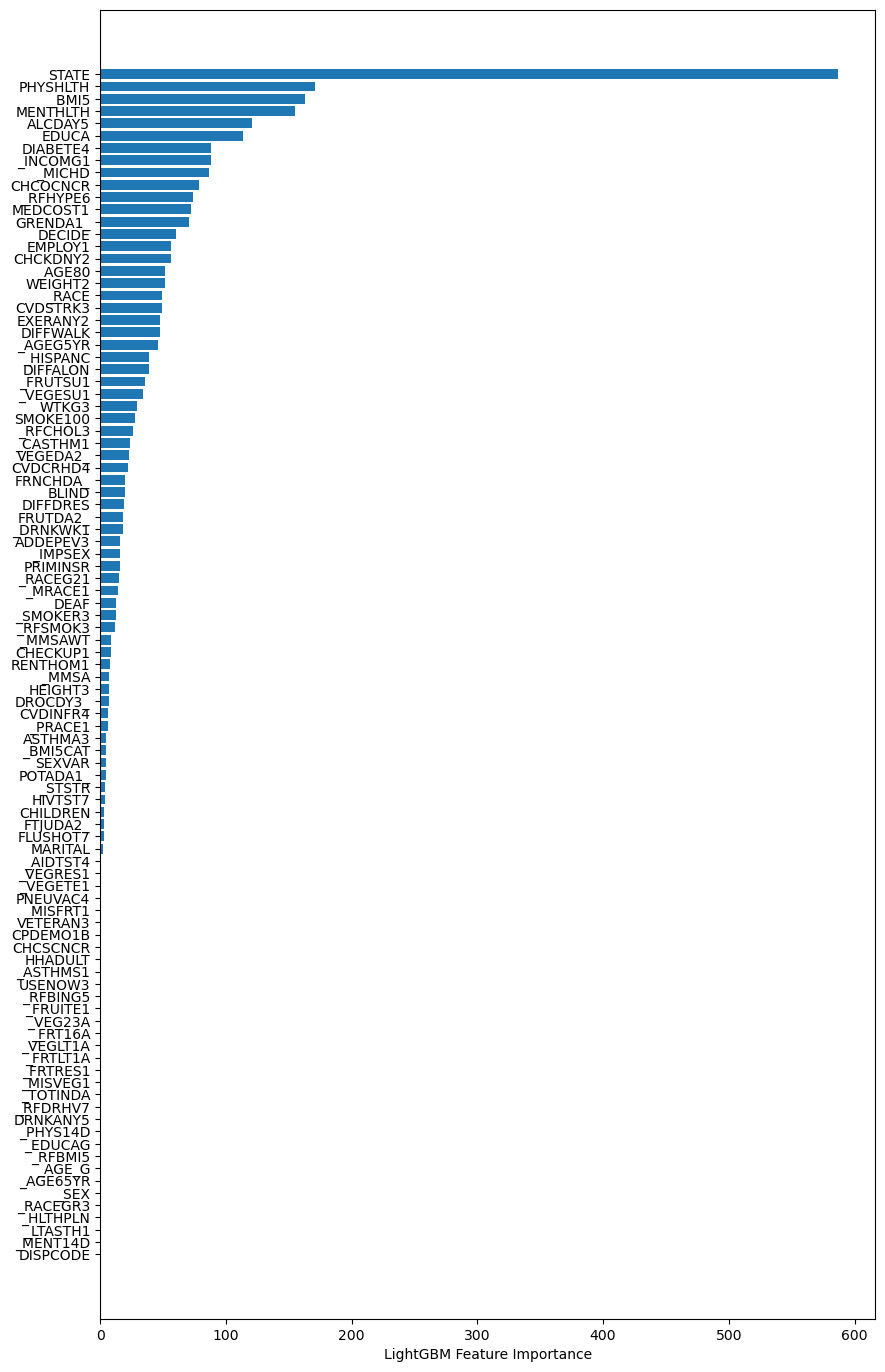

In [61]:
from lightgbm import LGBMClassifier

clf = LGBMClassifier(objective='binary', num_leaves=31, learning_rate=0.05, n_estimators=100)
clf.fit(X_train, y_train)


import matplotlib.pyplot as plt

# Get feature importances
importances = clf.feature_importances_

# Plot feature importances
features = X_train.columns
sorted_idx = importances.argsort()

plt.figure(figsize=(10, 17))
plt.barh(features[sorted_idx], importances[sorted_idx])
plt.xlabel("LightGBM Feature Importance")
plt.show()

In [62]:
# Number of top features
n = 45

# Get the indices of the top n features
top_indices = importances.argsort()[-n:][::-1]

# Display the top n features and their importances
top_features = features[top_indices]
top_importances = importances[top_indices]

for feature, importance in zip(top_features, top_importances):
    print(f"Feature: {feature}, Importance: {importance}")

Feature: STATE, Importance: 587
Feature: PHYSHLTH, Importance: 171
Feature: _BMI5, Importance: 163
Feature: MENTHLTH, Importance: 155
Feature: ALCDAY5, Importance: 121
Feature: EDUCA, Importance: 114
Feature: DIABETE4, Importance: 88
Feature: _INCOMG1, Importance: 88
Feature: _MICHD, Importance: 87
Feature: CHCOCNCR, Importance: 79
Feature: _RFHYPE6, Importance: 74
Feature: MEDCOST1, Importance: 72
Feature: GRENDA1_, Importance: 71
Feature: DECIDE, Importance: 60
Feature: EMPLOY1, Importance: 56
Feature: CHCKDNY2, Importance: 56
Feature: _AGE80, Importance: 52
Feature: WEIGHT2, Importance: 52
Feature: _RACE, Importance: 49
Feature: CVDSTRK3, Importance: 49
Feature: EXERANY2, Importance: 48
Feature: DIFFWALK, Importance: 48
Feature: _AGEG5YR, Importance: 46
Feature: _HISPANC, Importance: 39
Feature: DIFFALON, Importance: 39
Feature: _FRUTSU1, Importance: 36
Feature: _VEGESU1, Importance: 34
Feature: WTKG3, Importance: 29
Feature: SMOKE100, Importance: 28
Feature: _RFCHOL3, Importance: 2

In [63]:
#Lets look at the categorical features in the top n features
categorical_top_features = [feature for feature in top_features if X_train[feature].dtype == 'category']
for feature, importance in zip(categorical_top_features, top_importances):
    print(f"Cat feature: {feature}, Importance: {importance}")

Cat feature: STATE, Importance: 587
Cat feature: ALCDAY5, Importance: 171
Cat feature: EDUCA, Importance: 163
Cat feature: DIABETE4, Importance: 155
Cat feature: _INCOMG1, Importance: 121
Cat feature: _MICHD, Importance: 114
Cat feature: CHCOCNCR, Importance: 88
Cat feature: _RFHYPE6, Importance: 88
Cat feature: MEDCOST1, Importance: 87
Cat feature: DECIDE, Importance: 79
Cat feature: EMPLOY1, Importance: 74
Cat feature: CHCKDNY2, Importance: 72
Cat feature: _RACE, Importance: 71
Cat feature: CVDSTRK3, Importance: 60
Cat feature: EXERANY2, Importance: 56
Cat feature: DIFFWALK, Importance: 56
Cat feature: _AGEG5YR, Importance: 52
Cat feature: _HISPANC, Importance: 52
Cat feature: DIFFALON, Importance: 49
Cat feature: SMOKE100, Importance: 49
Cat feature: _RFCHOL3, Importance: 48
Cat feature: _CASTHM1, Importance: 48
Cat feature: CVDCRHD4, Importance: 46
Cat feature: BLIND, Importance: 39
Cat feature: DIFFDRES, Importance: 39
Cat feature: ADDEPEV3, Importance: 36
Cat feature: _IMPSEX, Im